# Examining new dataset from Zimmer lab

Lab homepage: <https://www.imp.ac.at/groups/manuel-zimmer/>

In [1]:
%matplotlib inline

In [2]:
import h5py
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

from viewers import ImageSliceViewer3D

### Load mCherry dataset from file

This dataset is 28 GB in size, so we need to be careful how much of it we try to load at once. 

#### Spec (copied from `README.md` file in Dropbox folder):

- Dataset Name: 'mCherry'
- No. of dimensions: 5 (v, c, z, y, x)
- Dimension Sizes: (1516, 1, 33, 650, 890)
- Max Dim. Size: (1516, 1, 33, 650, 890)
- Data Type: uint16
- Layout: CHUNKED (1, 1, 33, 650, 890)
- Compression: LZF
- Attributes:
  - 'elementsizeum': 3-element float64 array (µm) (z, y, x)


In [3]:
IN_FPATH = '/home/mn2822/Desktop/WormTracking/data/zimmer/mCherry_v00065-01581.hdf5'

with h5py.File(IN_FPATH, 'r') as f:
    dset = f.get('mCherry')
    frame = dset[500, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Plot max. projection of zoomed-in head

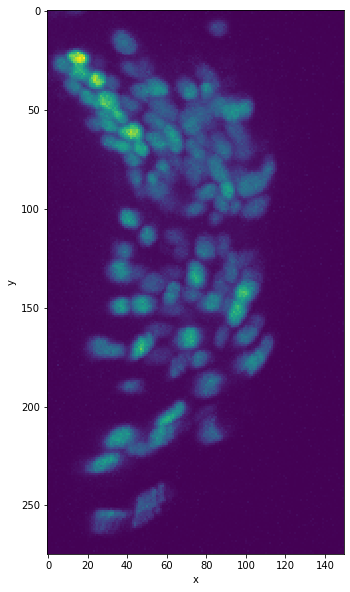

In [4]:
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]

plt.figure(figsize=(10, 10))
plt.imshow(np.max(img, 2).T);
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('zimmer_1.png')

### Use slice viewer to look at 3D structure of head image

In [5]:
ImageSliceViewer3D(np.swapaxes(img, 0, 1));

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

### Create video of max-projected worm motion

In [6]:
# Compute min and max values for video (these are used for conversion to 8-bit)

# with h5py.File(IN_FPATH, 'r') as f:
    
#     dset = f.get('mCherry')
 
#     min_vals = []
#     max_vals = []
#     for t in range(dset.shape[0]):
#         frame = dset[t, 0, :, :, :]
#         min_vals.append(np.min(frame))
#         max_vals.append(np.max(frame))
      
# vid_min = min(min_vals)
# vid_max = max(max_vals)

In [7]:
# t_start = 0
# t_end = 200

# with h5py.File(IN_FPATH, 'r') as f:
    
#     dset = f.get('mCherry')
    
#     frames = []
#     for t in range(t_start, t_end):
        
#         # Compute max projection
#         mp_16 = np.max(dset[t, 0, :, :, :], 0)
        
#         # Convert to 8-bit by scaling values
#         mp_8 = (mp_16 - vid_min) / (vid_max - vid_min) * 255
#         frames.append(np.uint8(mp_8))
    
#imageio.mimwrite('zimmer_maxproj.mp4', frames, fps=10)

In [34]:
t_start = 0
t_end = 1516
threshold = 250

with h5py.File(IN_FPATH, 'r') as f:
    
    dset = f.get('mCherry')
    
    frames_mp = []
    frames_am = []
    min_vals = []
    max_vals = []
    
    for t in range(t_start, t_end):
        
        frame = dset[t, 0, :, :, :]
        
        # Compute max projection
        mp_frame = np.max(frame, 0)
        frames_mp.append(mp_frame)
        
        # Compute 'argmax projection'
        am_frame = np.argmax(frame, 0)
        am_frame[mp_frame < threshold] = 0
        frames_am.append(am_frame)
        
        # Save min and max values
        min_vals.append(np.min(frame))
        max_vals.append(np.max(frame))
        
# Compute min and max values for whole video
vid_min = min(min_vals)
vid_max = max(max_vals)

# Create list of image plots
fig = plt.figure()
ims = []
for f in frames_am:
    im = plt.imshow(f, animated=True, vmin=0, vmax=33)
    ims.append([im])
    
plt.axis('off')
plt.colorbar()
    
# Compile images into animation object
ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1000)

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())

In [35]:
ani.save('zimmer_mp_color.mp4', fps=10)